In [2]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os

In [3]:
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)

,description,medical_specialty,sample_name,transcription,keywords
0,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a ""flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found ""passed out"" in bed, and when awoken appeared ...","neurology, ct brain, mri, moya moya, mci, brain, brainstem, brain hemorrhoids, cerebral angiogram, cerebral, cct, mets, moy moya disease, lacunar infarct, caudate nucleus, mcystectomy, mary, mact, mue, monia, momy, mca, brain and brain, cpt, mct,"
1,Blood in urine - Transitional cell cancer of the bladder.,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,","cardiovascular / pulmonary, progress note, chest pain, respiratory insufficiency, acuities, ventricular wall motion study at rest, laparoscopic cholecystectomy, endotracheal intubated spect, accuities, stapler at rest and without contrast, acudal posi..."
2,"This is a 66-year-old male with signs and symptoms of benign prostatic hypertrophy, who has had recurrent urinary retention since his kidney transplant. He passed his fill and pull study and was thought to self-catheterize in the event that he does i...",Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY OF PRESENT ILLNESS: , This is a 66-year-old gentleman status post deceased donor kidney transplant in 12/07, who has had recurrent urinary retention issues since that time. Most recently, he was hospitali...","urology, urinary retention issues, cystoscopy, nephrolithiasis, kidney transplant, renal insufficiency, renal disease, renal retention, renal failure, renal transplant, kidney cancer, renal, bladder, bladder and spleen, bladder neck fistula placements..."


In [4]:
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count
0,Surgery,526754
1,Consult - History and Phy.,287961
2,Orthopedic,198489
3,Cardiovascular / Pulmonary,160867
4,General Medicine,120978
5,Neurology,110677
6,Gastroenterology,80347
7,Radiology,74969
8,Obstetrics / Gynecology,72589
9,Urology,63419


In [5]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4966 non-null   object
 1   medical_specialty  4966 non-null   object
 2   sample_name        4966 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4966 non-null   object
dtypes: object(5)
memory usage: 232.8+ KB


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r'\w+')
df["tokens"] = df["transcription"].apply(tokenizer.tokenize)

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title('Sentence length histogram')
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, edgecolor = 'black', bins = 20)
plt.show()

In [6]:
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 72.5 

In [27]:
def learningRateExperimenting(learning_rate):


  print(os.listdir())

  datapath = "data"

  cuda_available = torch.cuda.is_available()

  def eval_metrics(actual, pred):
      bal_acc = balanced_accuracy_score(actual,pred)
      f1_sc = f1_score(actual,pred,average="weighted")
      return bal_acc, f1_sc


  def data_loader(df):
      num_classes = len(df['medical_specialty'].unique())
      class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
      df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
      df.dropna(inplace=True)
      df['transcription'] = df['keywords']+df['transcription']
      # df['transcription'] = df['transcription']

      X = df[['transcription']]
      y = df[["medical_specialty"]]


      train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

      # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
      class_weights = [1]*num_classes

      # print(df.head())

      return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


  if __name__ == '__main__':
      df = pd.read_csv("/content/data.csv")
      classes_to_replace = df['medical_specialty'].value_counts()[df['medical_specialty'].value_counts() < 50].index.tolist()

      # Replace classes with counts less than 50 with "Other"
      df['medical_specialty'] = df['medical_specialty'].apply(lambda x: 'Other' if x in classes_to_replace else x)

      train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

      train_df = pd.DataFrame(columns=['text','labels'])
      train_df['text'] = train_x['transcription']
      train_df['labels'] = train_y['medical_specialty']
      test_df = pd.DataFrame(columns=['text','labels'])
      test_df['text'] = test_x['transcription']
      test_df['labels'] = test_y['medical_specialty']
      print("----->",df["transcription"][0])



      # learning_rate = 1e-5
      num_of_epochs = 3
      print("222----->",df["transcription"][0])

      model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

      model = ClassificationModel(
          "roberta",
          "roberta-base",
          num_labels=num_classes,
          weight=class_weights,
          use_cuda=cuda_available,
          args=model_args
          )

      model.train_model(train_df)
      model.save_model()
      result, model_outputs, wrong_predictions = model.eval_model(test_df)




      result,output = model.predict(test_df['text'].values.tolist())
      cm = confusion_matrix(test_df['labels'], result)
      print(cm)
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_dict.keys(), yticklabels=class_dict.keys())
      plt.title('Confusion Matrix')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.show()



      acc, f1 = eval_metrics(test_df['labels'],result)

      return [acc,f1,result]



In [16]:
import seaborn as sns

['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> neurology, ct brain, mri, moya moya, mci, brain, brainstem, brain hemorrhoids, cerebral angiogram, cerebral, cct, mets, moy moya disease, lacunar infarct, caudate nucleus, mcystectomy, mary, mact, mue, monia, momy, mca, brain and brain, cpt, mct,CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

[[ 42   0   0   0   0   0   4   1   0   0   0   0   0   2   0   2   0   0
    0   1   0   4   0]
 [  0  36   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   2   0]
 [  0   0 256   0   0   0   0   0   0   3   0   0   0   0   0   1   0   3
    0   0   0   1   8]
 [  1   0   2  68   0   0   0   1   0   3   0   0   0   0   0   0   0   0
    1   2   0   2   0]
 [  0   0   0   0  33   0   0   0   0   1   0   0   0   0   0   2   0   0
    0   0   0   6   0]
 [  0   0   0   0   0  64   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   4]
 [  0   0   0   0   0   0  10   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   2   0]
 [  0   0   0   0   0   0   0  15   0   0   0   0   0   0   0   0   0   0
    0   1   0   1   0]
 [  0   0   0   0   0   0   0   0  15   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   3   0   0   0   0   0   0  81   0   0   0   0   0   1   1   0
    0   2   0   1   0]
 [  0   0   0   0   0   0   0 

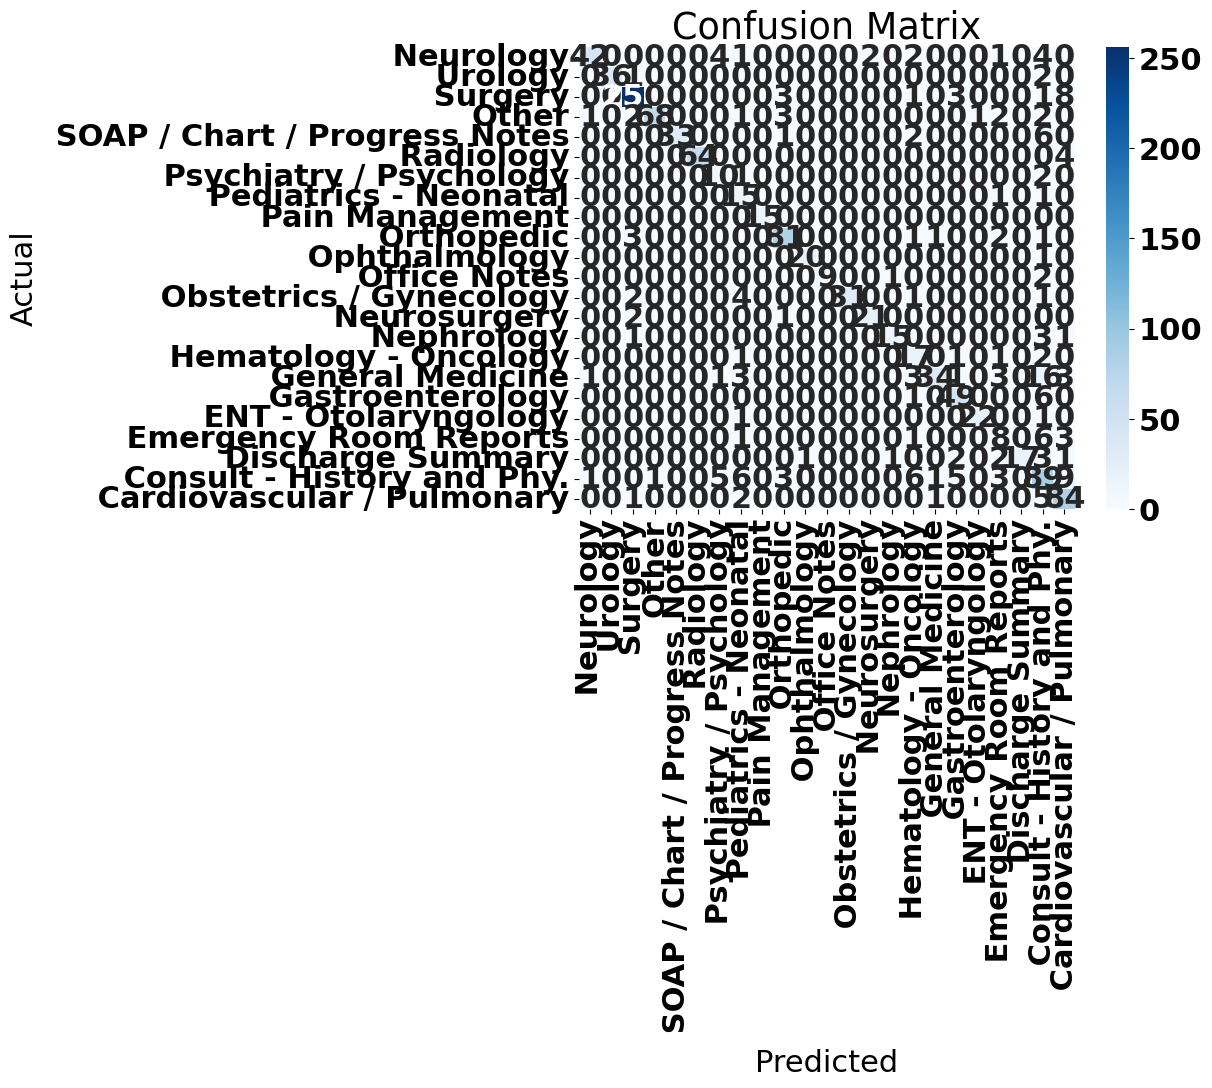

[0.8089736686056276, 0.8400925727401232, array([20,  2,  1, ..., 20, 22,  5])]

In [28]:
learningRateExperimenting(1e-4)

The word count of all transcription is: 2311419


<BarContainer object of 40 artists>

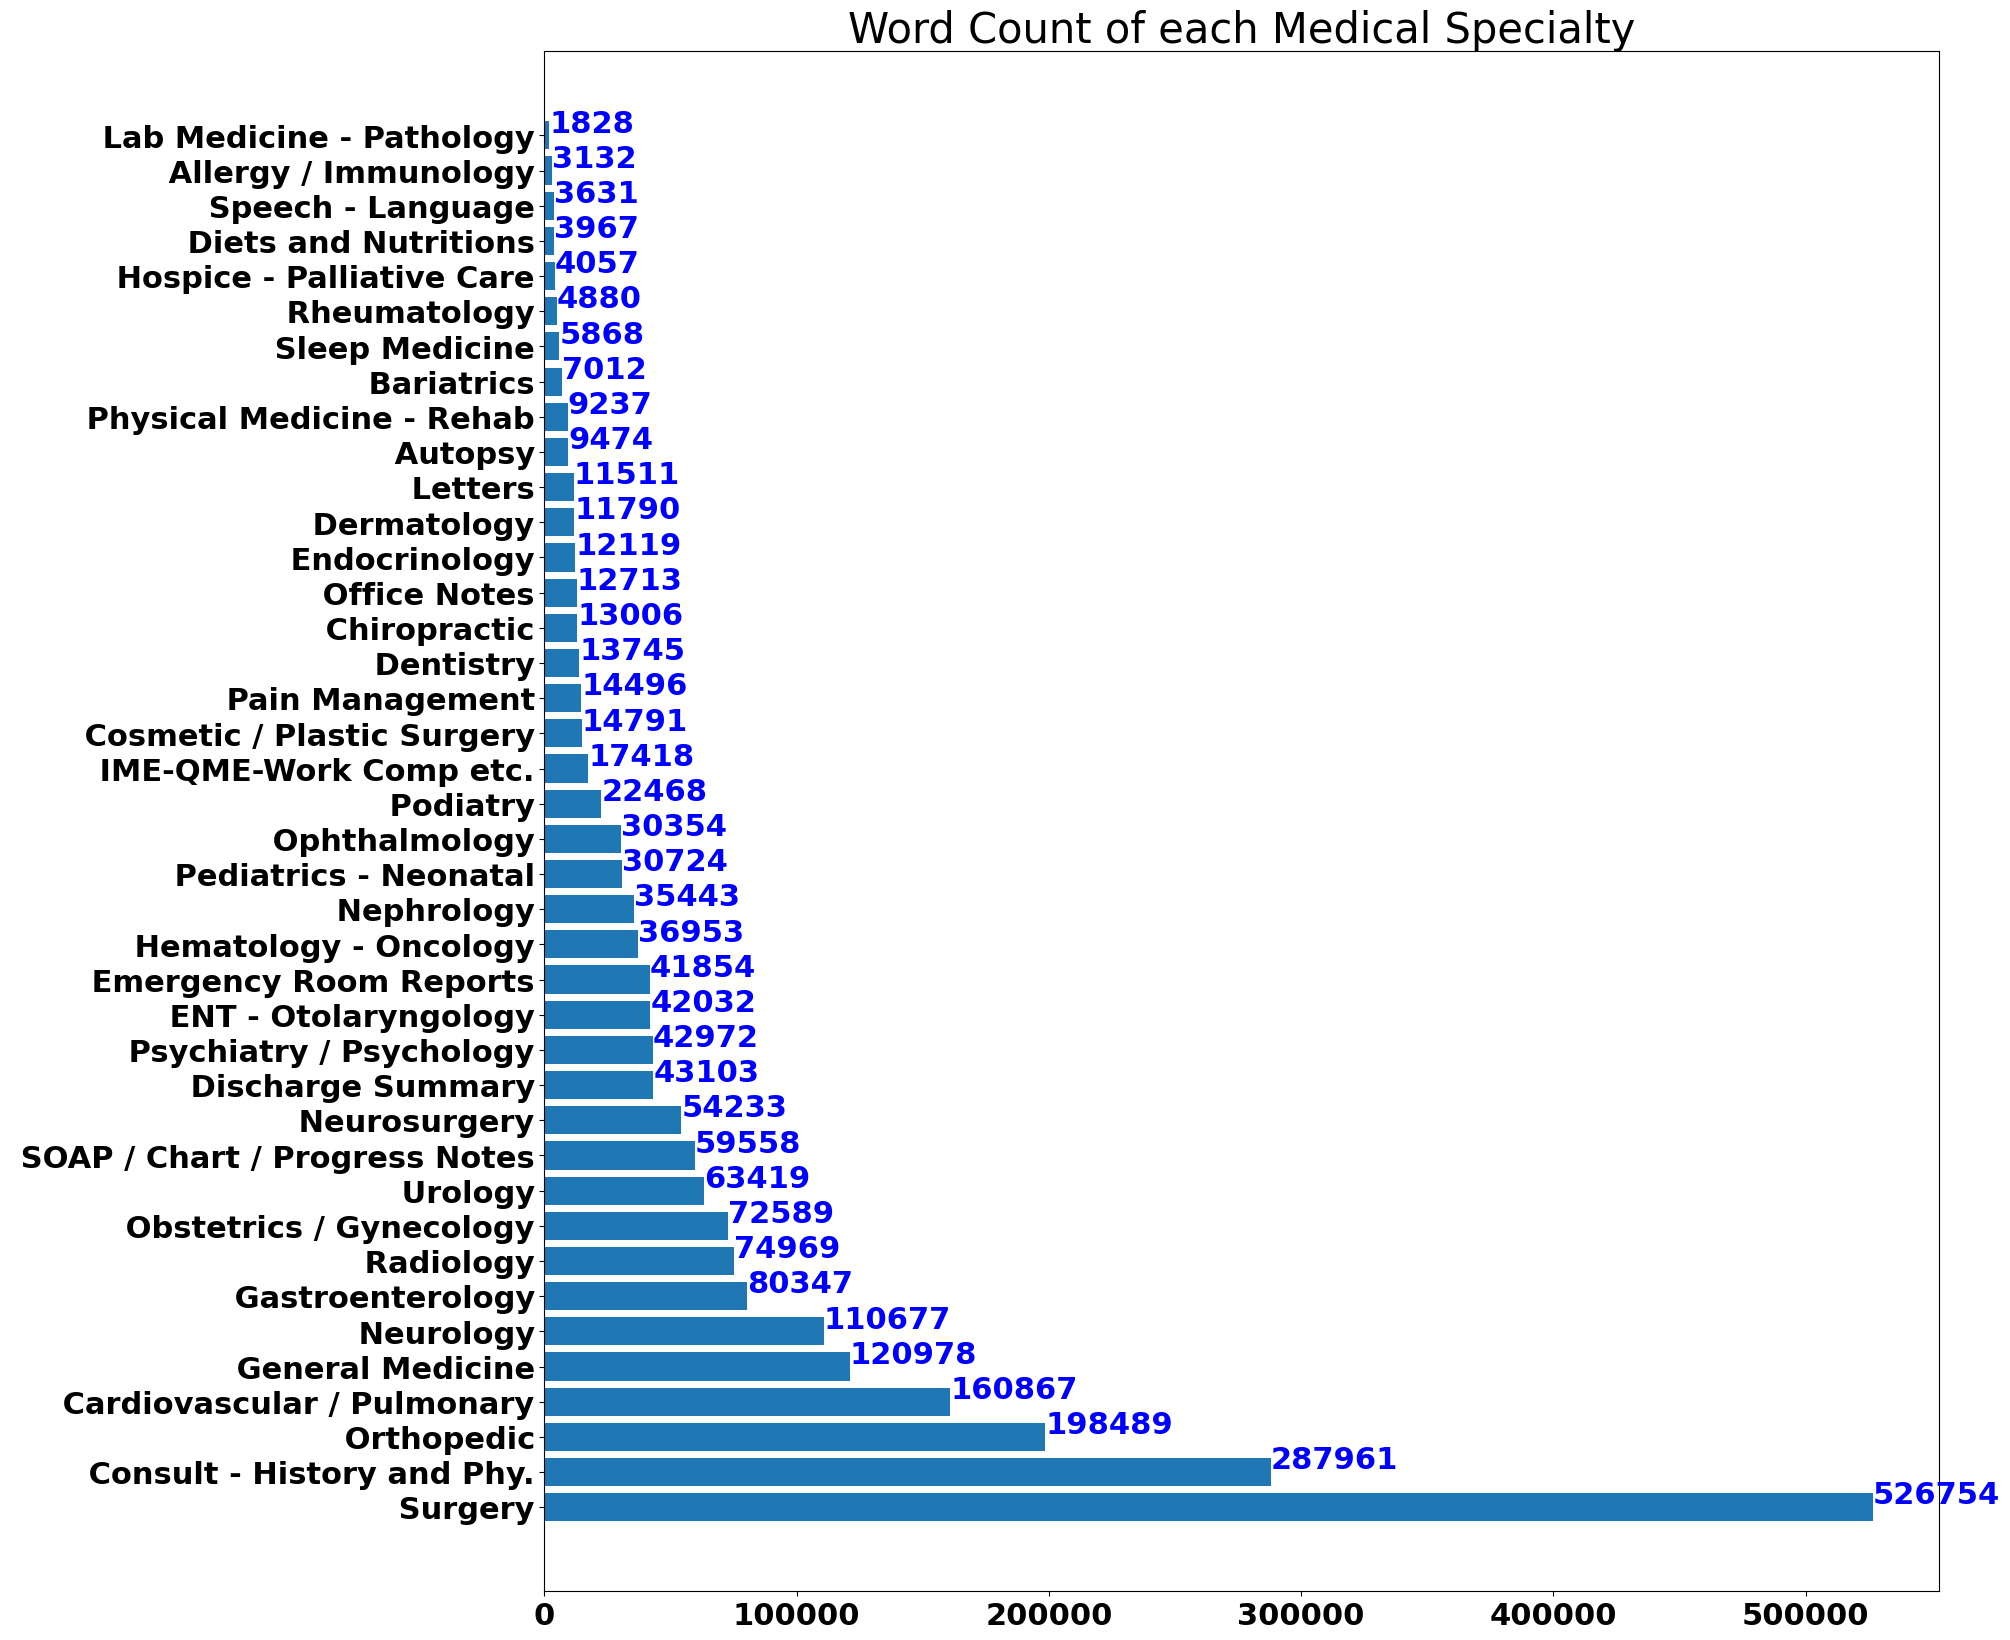

In [19]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
df = pd.read_csv("/content/data.csv")
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
def bar_plot(labels, value_counts, title):

    f, ax = plt.subplots(figsize=(18,20))
    ax.set_title(F'{title}' , fontsize=30)
    for i, v in enumerate(value_counts):
        v = round(v,1)
        ax.text(v + 0.1, i + 0.1, str(v), color='blue')
    return plt.barh(labels, value_counts)

total_word_count = df['transcription'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

bar_plot(word_count_df['Medical Specialty'].values, word_count_df['Word Count'].values,"Word Count of each Medical Specialty")

There are 40 target labels


<BarContainer object of 40 artists>

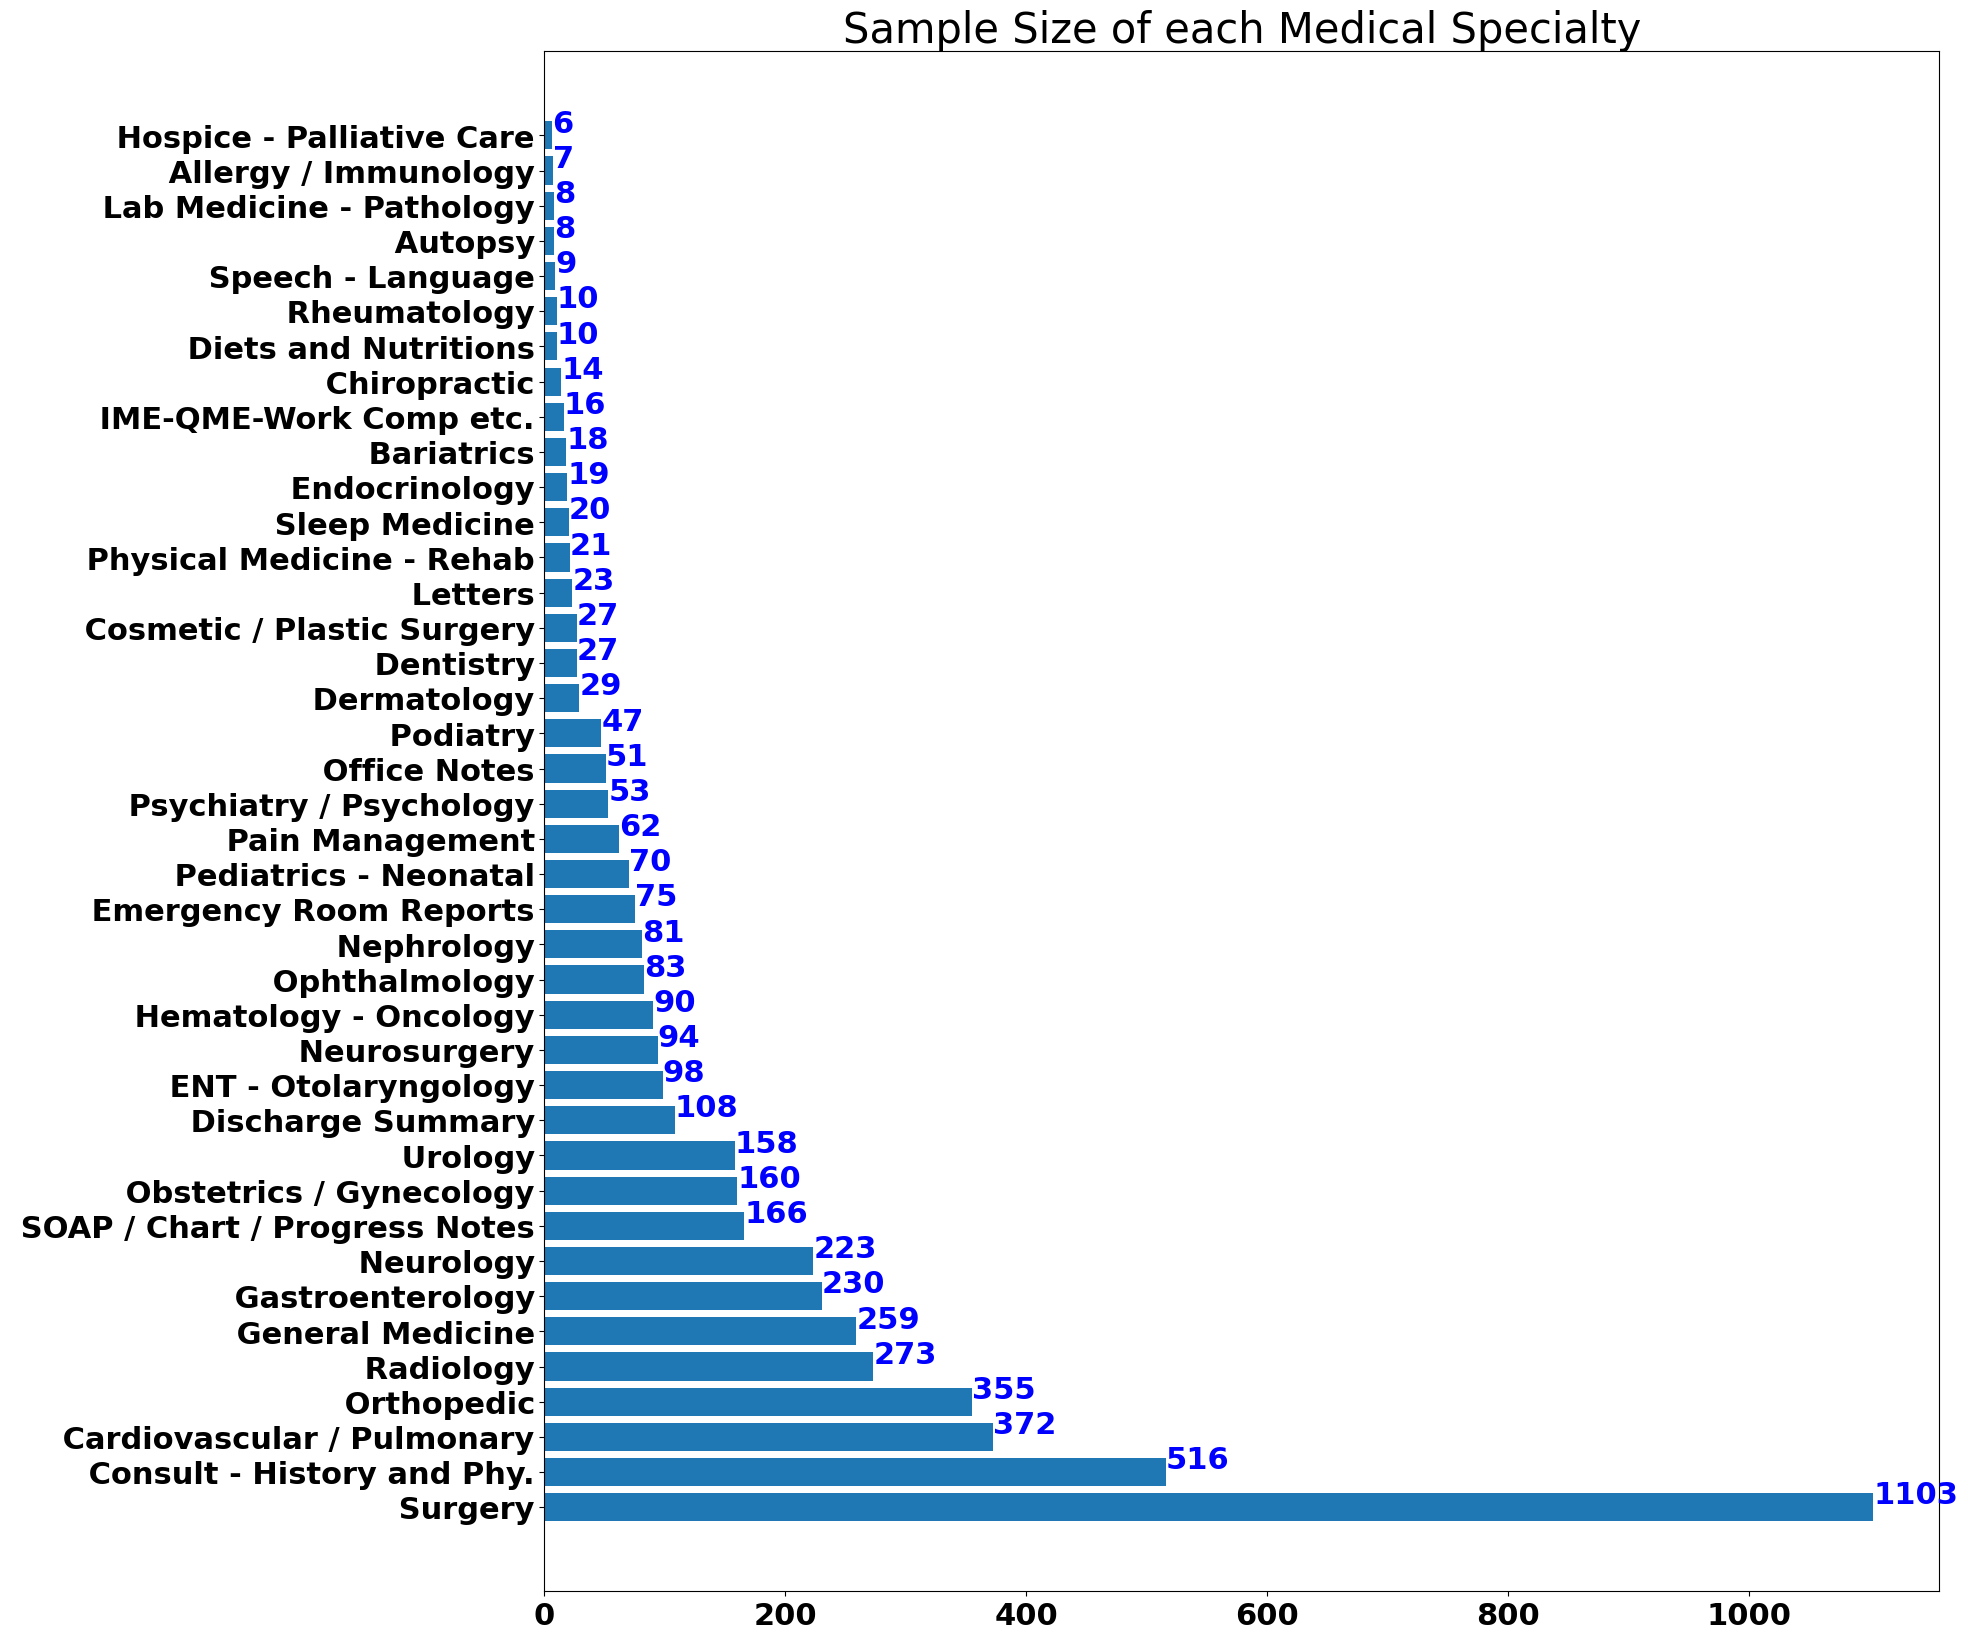

In [20]:
# function to flatten one list
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

# to convert value counts into list format
value_counts =df[['medical_specialty']].value_counts().rename_axis('medical_specialty').reset_index(name='value_counts')
labels = flat_list(value_counts[['medical_specialty']].values.tolist())
value_counts = flat_list(value_counts[['value_counts']].values.tolist())

# To count how many labels in the dataset`
print(f"There are {len(labels)} target labels")

bar_plot(labels,value_counts,"Sample Size of each Medical Specialty")

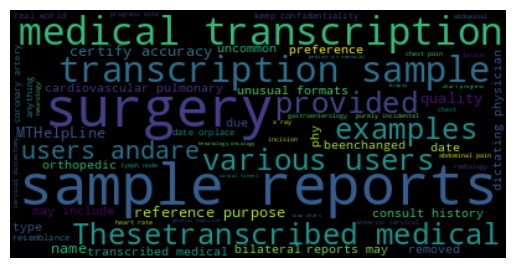

In [23]:
from wordcloud import WordCloud

def wordcloud(df):
    # Convert 'transcription' column to strings
    df['keywords'] = df['keywords'].astype(str)

    wordcloud_ent = WordCloud().generate(' '.join(df['keywords']))
    plt.imshow(wordcloud_ent, interpolation='bilinear')
    plt.axis("off")
    return plt.show()

# Assuming df is your DataFrame
wordcloud(df)


In [29]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
AccuracyAndF1 = {}
for i in learning_rates:
  AccuracyAndF1[i] = learningRateExperimenting(i)
  print("key is learning rate and value list is accuracy and F1 score-------->",AccuracyAndF1)

['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {0.01: [0.025, 0.07869014267268244]}
['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migra

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {0.01: [0.025, 0.07869014267268244], 0.001: [0.025, 0.07869014267268244]}
['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {0.01: [0.025, 0.07869014267268244], 0.001: [0.025, 0.07869014267268244], 0.0001: [0.7709611058671374, 0.8342525087501772]}
['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or v

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {0.01: [0.025, 0.07869014267268244], 0.001: [0.025, 0.07869014267268244], 0.0001: [0.7709611058671374, 0.8342525087501772], 1e-05: [0.6259643972135378, 0.836274493486896]}
['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, naus

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {0.01: [0.025, 0.07869014267268244], 0.001: [0.025, 0.07869014267268244], 0.0001: [0.7709611058671374, 0.8342525087501772], 1e-05: [0.6259643972135378, 0.836274493486896], 1e-06: [0.04884718422252622, 0.16194200601137015]}


In [6]:
def epochsExperimenting(num_of_epochs):


  print(os.listdir())

  datapath = "data"

  cuda_available = torch.cuda.is_available()

  def eval_metrics(actual, pred):
      bal_acc = balanced_accuracy_score(actual,pred)
      f1_sc = f1_score(actual,pred,average="weighted")
      return bal_acc, f1_sc


  def data_loader(df):
      num_classes = len(df['medical_specialty'].unique())
      class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
      df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
      df.dropna(inplace=True)
      df['transcription'] = df['keywords']+df['transcription']
      # df['transcription'] = df['transcription']

      X = df[['transcription']]
      y = df[["medical_specialty"]]


      train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

      # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
      class_weights = [1]*num_classes

      # print(df.head())

      return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


  if __name__ == '__main__':
      df = pd.read_csv("/content/data.csv")
      print("----->",df["transcription"][0])
      print("----->",df["keywords"][0])
      train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

      train_df = pd.DataFrame(columns=['text','labels'])
      train_df['text'] = train_x['transcription']
      train_df['labels'] = train_y['medical_specialty']
      test_df = pd.DataFrame(columns=['text','labels'])
      test_df['text'] = test_x['transcription']
      test_df['labels'] = test_y['medical_specialty']
      print("----->",df["transcription"][0])



      learning_rate = 1e-5
      # num_of_epochs = 3
      print("222----->",df["transcription"][0])

      model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

      model = ClassificationModel(
          "roberta",
          "roberta-base",
          num_labels=num_classes,
          weight=class_weights,
          use_cuda=cuda_available,
          args=model_args
          )

      model.train_model(train_df)
      model.save_model()
      result, model_outputs, wrong_predictions = model.eval_model(test_df)




      result,output = model.predict(test_df['text'].values.tolist())



      acc, f1 = eval_metrics(test_df['labels'],result)

      return [acc,f1]



In [7]:
Epochs = [3,5,7,9,11]
AccuracyAndF1 = {}
for i in Epochs:
  AccuracyAndF1[i] = epochsExperimenting(i)
  print("key is learning rate and value list is accuracy and F1 score-------->",AccuracyAndF1)

['.config', 'data.csv', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {3: [0.6768081928033547, 0.8346266048742144]}
['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PM

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {3: [0.6768081928033547, 0.8346266048742144], 5: [0.697558556382187, 0.8254487766304012]}
['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {3: [0.6768081928033547, 0.8346266048742144], 5: [0.697558556382187, 0.8254487766304012], 7: [0.7277900477741217, 0.816205893560962]}
['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stif

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Running Epoch 0 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 3 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 4 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 5 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 6 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 7 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 8 of 9:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {3: [0.6768081928033547, 0.8346266048742144], 5: [0.697558556382187, 0.8254487766304012], 7: [0.7277900477741217, 0.816205893560962], 9: [0.7514669794619027, 0.8103560275987405]}
['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headach

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/11 [00:00<?, ?it/s]

Running Epoch 0 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 3 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 4 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 5 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 6 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 7 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 8 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 9 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 10 of 11:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

key is learning rate and value list is accuracy and F1 score--------> {3: [0.6768081928033547, 0.8346266048742144], 5: [0.697558556382187, 0.8254487766304012], 7: [0.7277900477741217, 0.816205893560962], 9: [0.7514669794619027, 0.8103560275987405], 11: [0.7561707422652666, 0.7937553791378493]}


In [4]:
def epochsExperimenting(num_of_epochs):


  print(os.listdir())

  datapath = "data"

  cuda_available = torch.cuda.is_available()

  def eval_metrics(actual, pred):
      bal_acc = balanced_accuracy_score(actual,pred)
      f1_sc = f1_score(actual,pred,average="weighted")
      return bal_acc, f1_sc


  def data_loader(df):
      num_classes = len(df['medical_specialty'].unique())
      class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
      df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
      df.dropna(inplace=True)
      df['transcription'] = df['keywords']+df['transcription']
      # df['transcription'] = df['transcription']

      X = df[['transcription']]
      y = df[["medical_specialty"]]


      train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

      # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
      class_weights = [1]*num_classes

      # print(df.head())

      return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


  if __name__ == '__main__':
      df = pd.read_csv("/content/data.csv")
      print("----->",df["transcription"][0])
      print("----->",df["keywords"][0])
      train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

      train_df = pd.DataFrame(columns=['text','labels'])
      train_df['text'] = train_x['transcription']
      train_df['labels'] = train_y['medical_specialty']
      test_df = pd.DataFrame(columns=['text','labels'])
      test_df['text'] = test_x['transcription']
      test_df['labels'] = test_y['medical_specialty']
      print("----->",df["transcription"][0])



      learning_rate = 1e-5
      # num_of_epochs = 3
      print("222----->",df["transcription"][0])
      import transformers
      from transformers import AlbertForSequenceClassification, AlbertTokenizer, Trainer, TrainingArguments
      # Load ALBERT tokenizer and model
      tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")  # Load tokenizer
      model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=num_classes)  # Load model with correct number of labels

      # Set up training arguments (using Trainer for more flexibility)
      training_args = TrainingArguments(
          num_train_epochs=num_of_epochs,
          learning_rate=learning_rate,
          output_dir="./albert_output",  # Adjust output directory as needed
          overwrite_output_dir=True,
          per_device_train_batch_size=16,  # Adjust batch size if needed
          save_steps=500,  # Save model every 500 steps
          evaluation_strategy="epoch",  # Evaluate after each epoch
      )

      # Create Trainer instance
      trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=train_df,
          eval_dataset=test_df,
          tokenizer=tokenizer,
          compute_metrics=eval_metrics,  # Assuming eval_metrics is defined elsewhere
      )

      # Train the model
      trainer.train()

      # Save the trained model
      trainer.save_model("./albert_model")  # Adjust save path if needed

      # Evaluate on the test set
      result = trainer.evaluate()

      # Make predictions on new text
      texts = test_df['text'].values.tolist()
      predictions, raw_outputs = trainer.predict(texts)

      # Calculate accuracy and F1-score
      acc, f1 = eval_metrics(test_df['labels'], predictions)

      return [acc, f1]


In [5]:
epochsExperimenting(3)

['.config', 'runs', 'data.csv', 'outputs', 'cache_dir', 'sample_data']
-----> CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


KeyError: 3606

In [20]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
